In [537]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.ensemble import *
from sklearn.preprocessing import normalize
import math
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import time
from sklearn import model_selection
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix as cm
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical
from itertools import combinations
from catboost import CatBoostClassifier, cv, Pool 
from tqdm.notebook import tqdm

In [33]:
np.set_printoptions(precision=5)
pd.set_option('display.max_rows', 100)

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# EDA

In [5]:
df_train.sample(5)

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
14208,14209,2626,345,13,120,15,2052,193,218,164,...,0,0,0,0,0,0,0,0,0,6
9848,9849,3143,1,24,787,-11,1207,178,187,141,...,0,0,0,0,0,0,0,0,0,1
9133,9134,3075,90,5,30,-2,1425,227,232,139,...,0,0,0,0,0,0,0,0,0,1
9884,9885,3143,300,13,721,222,3274,183,234,191,...,0,0,0,0,0,0,0,0,0,1
13536,13537,2930,169,18,595,98,685,231,244,138,...,0,0,0,0,0,0,0,0,0,5


In [7]:
df_train.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

Aspect


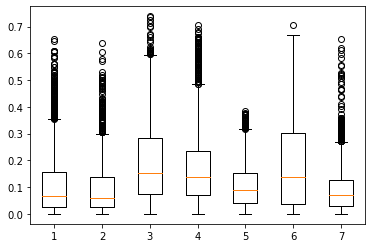

Slope


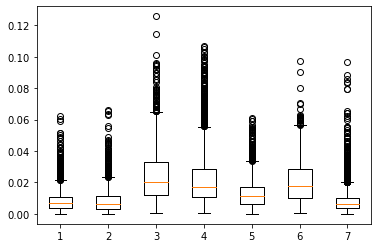

Horizontal_Distance_To_Hydrology


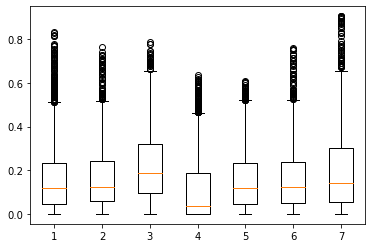

Vertical_Distance_To_Hydrology


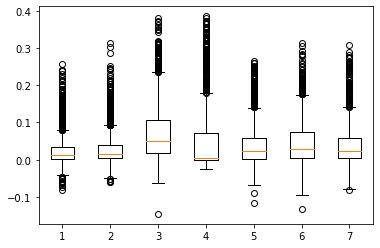

Hillshade_9am


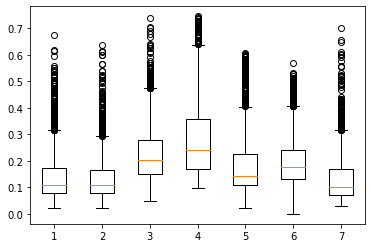

Hillshade_Noon


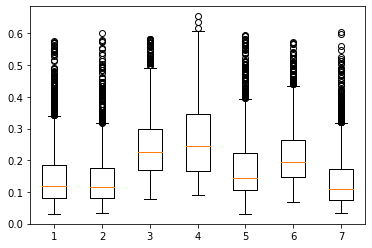

Hillshade_3pm


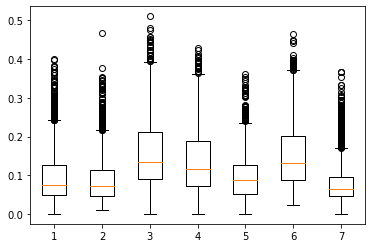

Horizontal_Distance_To_Fire_Points


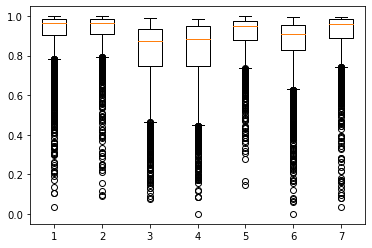

In [11]:
col_normalize = ['Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points']
df_train_norm = df_train.copy()
df_train_norm[col_normalize] = normalize(df_train[col_normalize])
for col in col_normalize:
    print(col)
    l = []
    for cover in sorted(df_train_norm.Cover_Type.unique()):
        l.append( [v for v,k in zip(df_train_norm[col],df_train_norm['Cover_Type']) if k==cover]
                )
    plt.boxplot(l)
    plt.show()

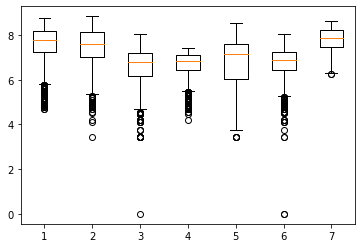

In [8]:
l = []
for cover in sorted(df_train_norm.Cover_Type.unique()):
    l.append( [math.log(v+1) for v,k in zip(df_train_norm['Horizontal_Distance_To_Roadways'],df_train_norm['Cover_Type']) if k==cover]
            )
plt.boxplot(l)
plt.show()

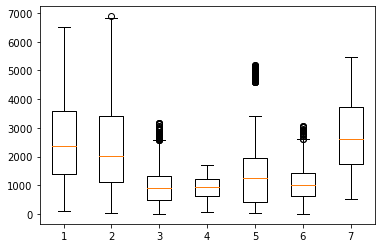

In [9]:
l = []
for cover in sorted(df_train_norm.Cover_Type.unique()):
    l.append( [v for v,k in zip(df_train_norm['Horizontal_Distance_To_Roadways'],df_train_norm['Cover_Type']) if k==cover]
            )
plt.boxplot(l)
plt.show()

results = []
for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]:
    pca = PCA(n_components=k)
    pca.fit(df_train_norm.to_numpy(), df_train_norm['Cover_Type'].to_numpy())
    explained_variance = pca.explained_variance_ratio_.sum()
    print("k={}:\t{}".format(k,explained_variance))
    results.append([k, explained_variance])
plt.plot(np.array(results)[:,0], np.array(results)[:,1])

In [769]:
soils = [x for x in df_train_norm.columns if "Soil" in x]

for x in combinations(soils, 3):
    print(x)
    break

df_train_norm[soils].sum(axis=1).value_counts()

from tqdm.notebook import tqdm

classes = []
for n in tqdm(range(2,6)):
    for x in tqdm(combinations(soils, n)):
        pca = PCA(n_components=1)
        pca.fit(df_train_norm[list(x)].to_numpy(), df_train_norm['Cover_Type'].to_numpy())
        explained_variance = pca.explained_variance_ratio_.sum()
        classes.append([*x] + [" "]*(5-n) + [explained_variance])

r = pd.DataFrame(classes, columns=['S1','S2','S3','S4','S5','var'])
r['var'] -= 1
r[r['var']>=0].sort_values('var',ascending=False)

r.sort_values('var',ascending=False).to_csv('PCA results.csv', index=False)

results = []
for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]:
    pca = TruncatedSVD(n_components=k)
    pca.fit(df_train_norm.to_numpy(), df_train_norm['Cover_Type'].to_numpy())
    explained_variance = pca.explained_variance_ratio_.sum()
    print("k={}:\t{}".format(k,explained_variance))
    results.append([k, explained_variance])
plt.plot(np.array(results)[:,0], np.array(results)[:,1])

In [1]:
# class 1-2

In [2]:
# class 3-6
# class 3-4
# class 3-4-6

# Helper Funtions

In [4]:
df_train

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,15116,2607,243,23,258,7,660,170,251,214,...,0,0,0,0,0,0,0,0,0,3
15116,15117,2603,121,19,633,195,618,249,221,91,...,0,0,0,0,0,0,0,0,0,3
15117,15118,2492,134,25,365,117,335,250,220,83,...,0,0,0,0,0,0,0,0,0,3
15118,15119,2487,167,28,218,101,242,229,237,119,...,0,0,0,0,0,0,0,0,0,3


In [5]:
kfold = model_selection.KFold(n_splits=10, random_state=0, shuffle=True)

In [652]:
def pipeline(df, version=0):
    # 0.8658068783068783
    df_n = df.copy()
    df_n.drop(columns=['Id'],inplace=True)
    df_n = df_n.astype({c:'bool' for c in df_n.columns if "Soil_Type" in c or "Wilderness_Area" in c})
    if version >= 1: # 0.893320105820106
        col_normalize = ['Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 
                     'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points',
                     'Horizontal_Distance_To_Roadways']
        df_n['log_Horizontal_Distance_To_Roadways'] = np.log(df_n['Horizontal_Distance_To_Roadways']+1)
        df_n['log_Horizontal_Distance_To_Fire_Points'] = np.log(df_n['Horizontal_Distance_To_Fire_Points']+1)
        df_n[col_normalize] = normalize(df_n[col_normalize])
        df_n.drop(columns=['Soil_Type7'],inplace=True)
    if version >= 2: # 0.8964947089947091
        df_n['sq_Elevation'] = np.power(df['Elevation'],1.5)
        df_n.drop(columns='Aspect',inplace=True)
        df_n['norm_aspect'] = df_train.Aspect.map(lambda x: x-180 if x > 180 else x+180) # np.abs(df.Aspect - 180)
        df_n['atan_aspect'] = np.arctan(df_n.norm_aspect)
    if version >= 3: # 0.9104497354497356
        df_n['Vertical_Distance_To_Hydrology'] = np.abs(df_n.Vertical_Distance_To_Hydrology)
        df_n['E-VH'] = df_train.Elevation - df_train.Vertical_Distance_To_Hydrology * .9 
        df_n['E-HH'] = df_train.Elevation - df_train.Horizontal_Distance_To_Hydrology * .5
        
        df_n['F+R'] = (df_train.Horizontal_Distance_To_Fire_Points + df_train.Horizontal_Distance_To_Roadways) ** 2
        df_n['F+H'] = (df_train.Horizontal_Distance_To_Fire_Points + df_train.Horizontal_Distance_To_Hydrology) ** 0.3
        df_n['H+R'] = (df_train.Horizontal_Distance_To_Hydrology + df_train.Horizontal_Distance_To_Roadways)
        
        df_n['abs_H-R'] = (np.abs(df_train.Horizontal_Distance_To_Hydrology - df_train.Horizontal_Distance_To_Roadways)) 
        df_n['abs_H-F'] = (np.abs(df_train.Horizontal_Distance_To_Hydrology - df_train.Horizontal_Distance_To_Fire_Points)) 
        df_n['abs_F-R'] = (np.abs(df_train.Horizontal_Distance_To_Fire_Points - df_train.Horizontal_Distance_To_Roadways)) 
    return df_n

def submit(model,version):
    global df_train
    df_train_c = pipeline(df_train.copy(),version)
    df_submit = pipeline(df_test.copy(),version)
    X, Y = df_train_c.drop(columns=['Cover_Type']).to_numpy(), df_train_c.Cover_Type.to_numpy()
    model.fit(X, Y)
    pred = model.predict(df_submit.to_numpy())
    final_df = df_test.copy()
    final_df['Cover_Type'] = pred
    return final_df[['Id','Cover_Type']]

In [535]:
def score_model(model,df, return_val=False, return_train=False, display=True, return_acc=False, return_time=False, show_weights=False, return_cv_acc=False, verbose=True):
    X , Y = df.drop(columns=['Cover_Type']).to_numpy(), df.Cover_Type.to_numpy()
    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=.33, random_state=0)
    start = time.time()
    results = model_selection.cross_val_score(model, X, Y, cv=kfold)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    acc = accuracy_score(y_val, pred)
    end = time.time()
    cv_acc = results.mean()
    if verbose:
        print('cv acc:', cv_acc)
        print('split acc:', acc)
        print('time taken:', end-start, end='\n\n')
    if display:
        matrix = cm(y_val, pred)
        print(matrix.diagonal() / matrix.sum(axis=1))

        disp = plot_confusion_matrix(model, X_val, y_val, display_labels=set(y_train), cmap=plt.cm.Blues, normalize='true')
        plt.show()
    
    if show_weights:
        for w,k in sorted(list(zip(model.feature_importances_, df.drop(columns=['Cover_Type']).columns)), key=lambda x: x[0]):
            print(k,w)
            
    # return all data
    return_data = [model]
    if return_train:
        return_data += [X_train, y_train]
    if return_val:
        return_data += [X_val, y_val]
    if return_acc:
        return_data += [acc]
    if return_cv_acc:
        return_data += [cv_acc]
    if return_time:
        return_data += [end-start]
    return tuple(return_data)

# Baseline

### Best Model = ExtraTreesClassifier()

cv acc: 0.8658068783068783
split acc: 0.8482965931863727
time taken: 14.883414268493652
[0.7571  0.67234 0.81818 0.96078 0.92533 0.84469 0.96073]


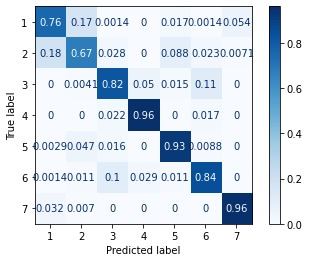

cv acc: 0.8642195767195766
split acc: 0.8434869739478958
time taken: 435.17900037765503
[0.75852 0.63262 0.82632 0.95798 0.93997 0.82834 0.96213]


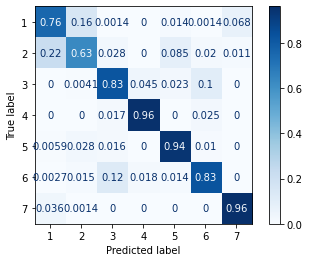

cv acc: 0.8653439153439153
split acc: 0.8448897795591183
time taken: 11.589077472686768
[0.76278 0.6766  0.81004 0.96078 0.92972 0.81744 0.95933]


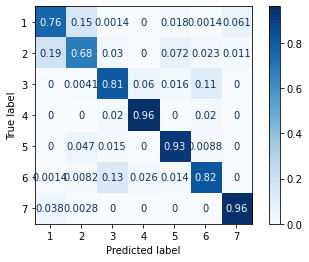

In [781]:
models = []
for clf in [ExtraTreesClassifier(n_jobs=-1, random_state=0),
           HistGradientBoostingClassifier(random_state=0),
           RandomForestClassifier(n_jobs=-1, random_state=0)]:
    
    models.append(score_model(clf,df_train))

### Best Ensemble = Mix 3

cv acc: 0.8854497354497355
split acc: 0.8639278557114228
time taken: 79.07685208320618
[0.76847 0.68936 0.85075 0.96779 0.94876 0.8515  0.97195]


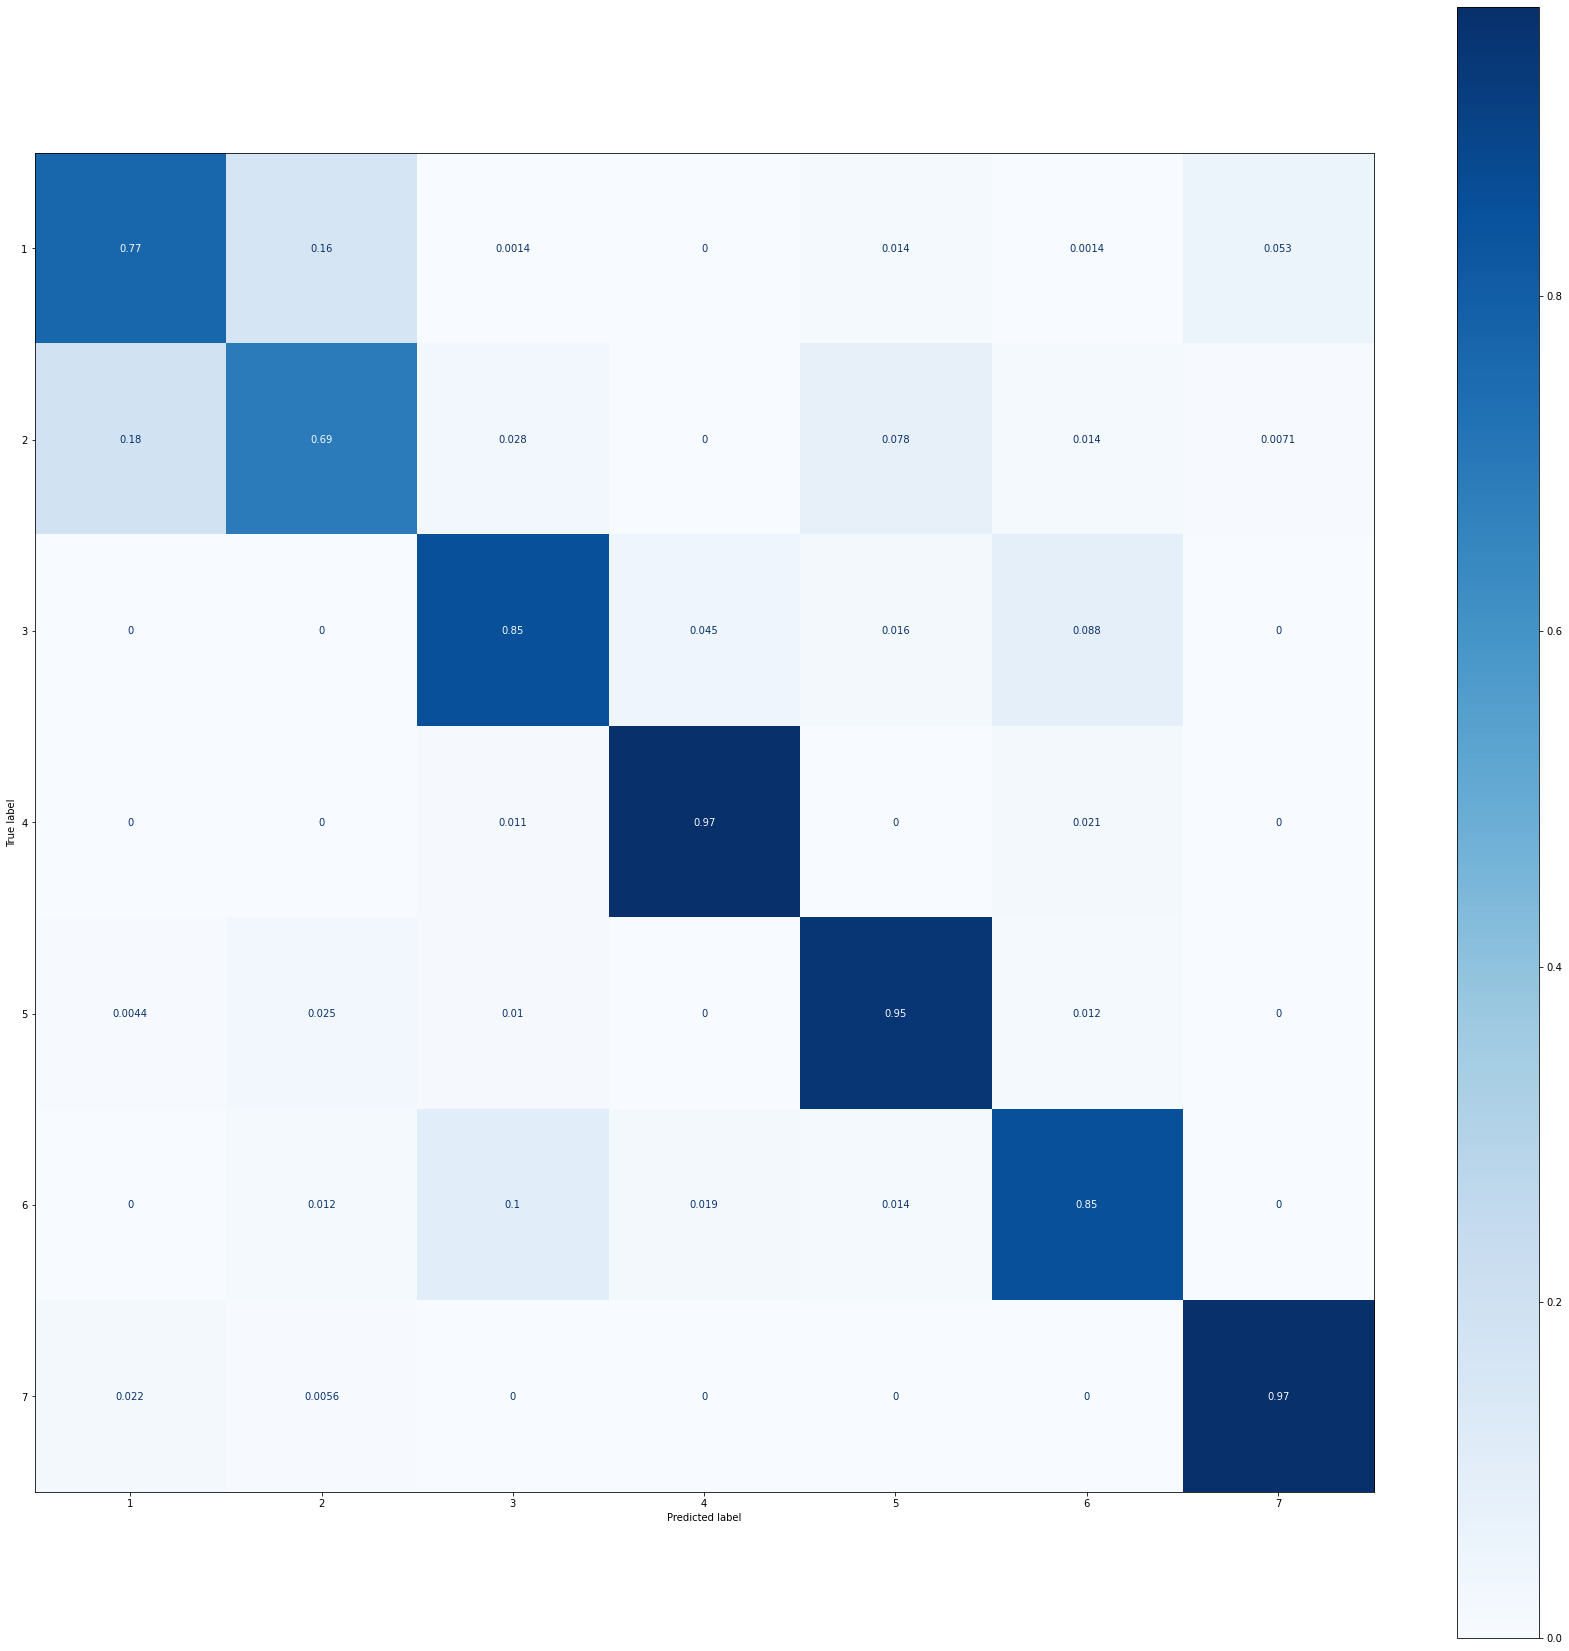

VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                 

In [302]:
# Voting
models = [('et',ExtraTreesClassifier(n_jobs=-1, random_state=0)),
           ('hg',HistGradientBoostingClassifier(random_state=0)),
           ('rf',RandomForestClassifier(n_jobs=-1, random_state=0))]
model = VotingClassifier(models, n_jobs=-1)
score_model(model,df_train);

cv acc: 0.8659391534391535
split acc: 0.8466933867735471
time taken: 76.25454878807068
[0.74858 0.65532 0.82904 0.96218 0.93411 0.84332 0.95512]


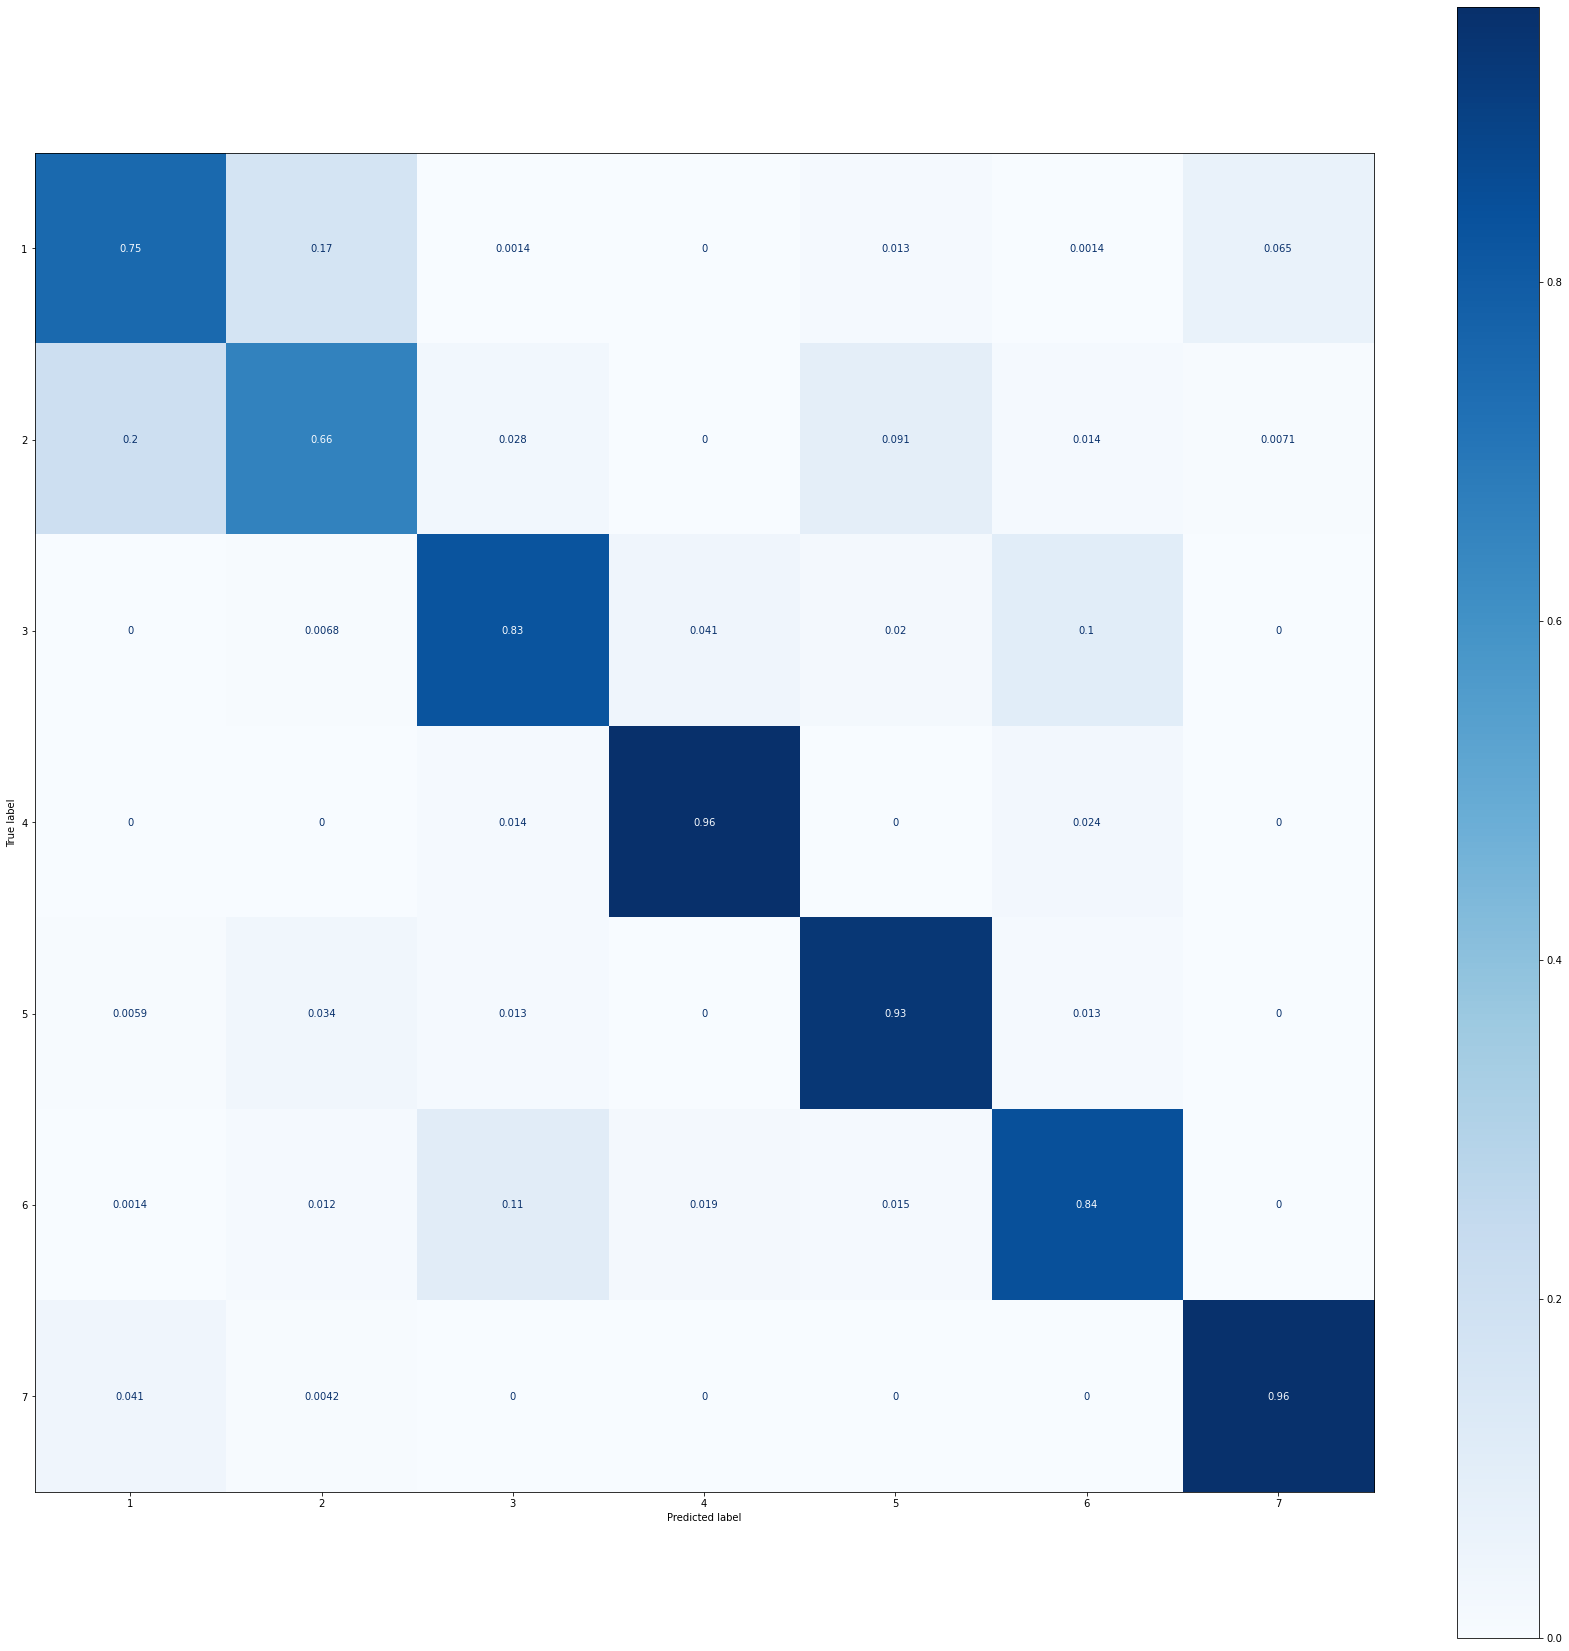

VotingClassifier(estimators=[('hg1',
                              HistGradientBoostingClassifier(l2_regularization=0.0,
                                                             learning_rate=0.1,
                                                             loss='auto',
                                                             max_bins=255,
                                                             max_depth=None,
                                                             max_iter=100,
                                                             max_leaf_nodes=31,
                                                             min_samples_leaf=20,
                                                             n_iter_no_change=None,
                                                             random_state=0,
                                                             scoring=None,
                                                             tol=1e-07,
                            

In [303]:
# Voting
models = [('hg1',HistGradientBoostingClassifier(random_state=0)),
           ('hg2',HistGradientBoostingClassifier(random_state=0)),
           ('hg3',HistGradientBoostingClassifier(random_state=0))]
model = VotingClassifier(models, n_jobs=-1)
score_model(model,df_train);

cv acc: 0.8873677248677249
split acc: 0.8681362725450902
time taken: 25.90005135536194
[0.74574 0.71915 0.86296 0.96779 0.94729 0.85831 0.97616]


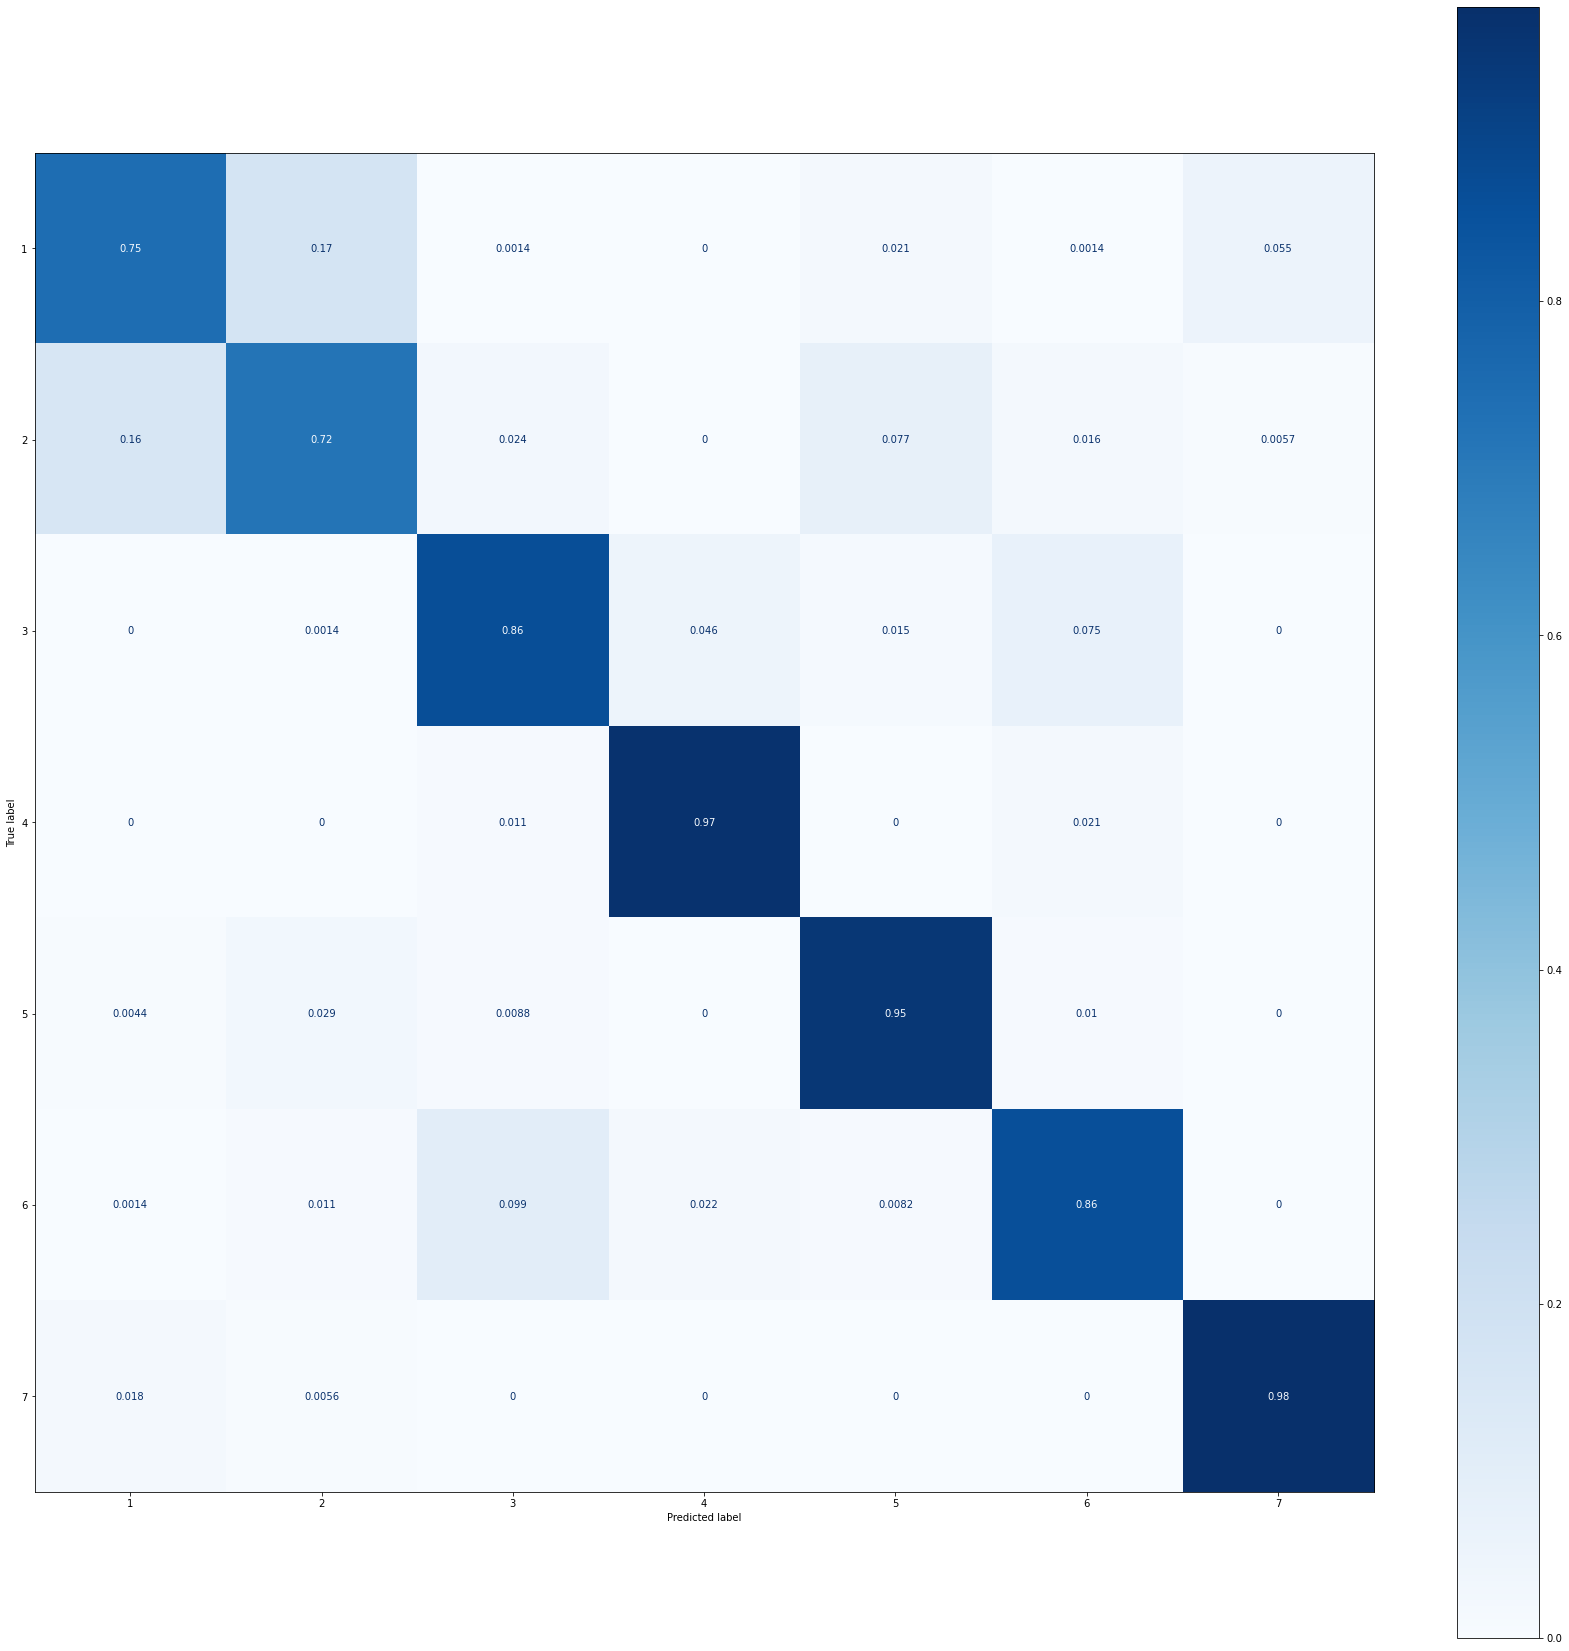

VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                 

In [304]:
# Voting
models = [('et',ExtraTreesClassifier(n_jobs=-1, random_state=0)),
           ('et2',ExtraTreesClassifier(n_jobs=-1, random_state=0)),
           ('et3',ExtraTreesClassifier(n_jobs=-1, random_state=0))]
model = VotingClassifier(models, n_jobs=-1)
score_model(model,df_train);

cv acc: 0.8774470899470901
split acc: 0.8585170340681363
time taken: 16.610207080841064
[0.76989 0.68794 0.83718 0.96218 0.9429  0.84332 0.96774]


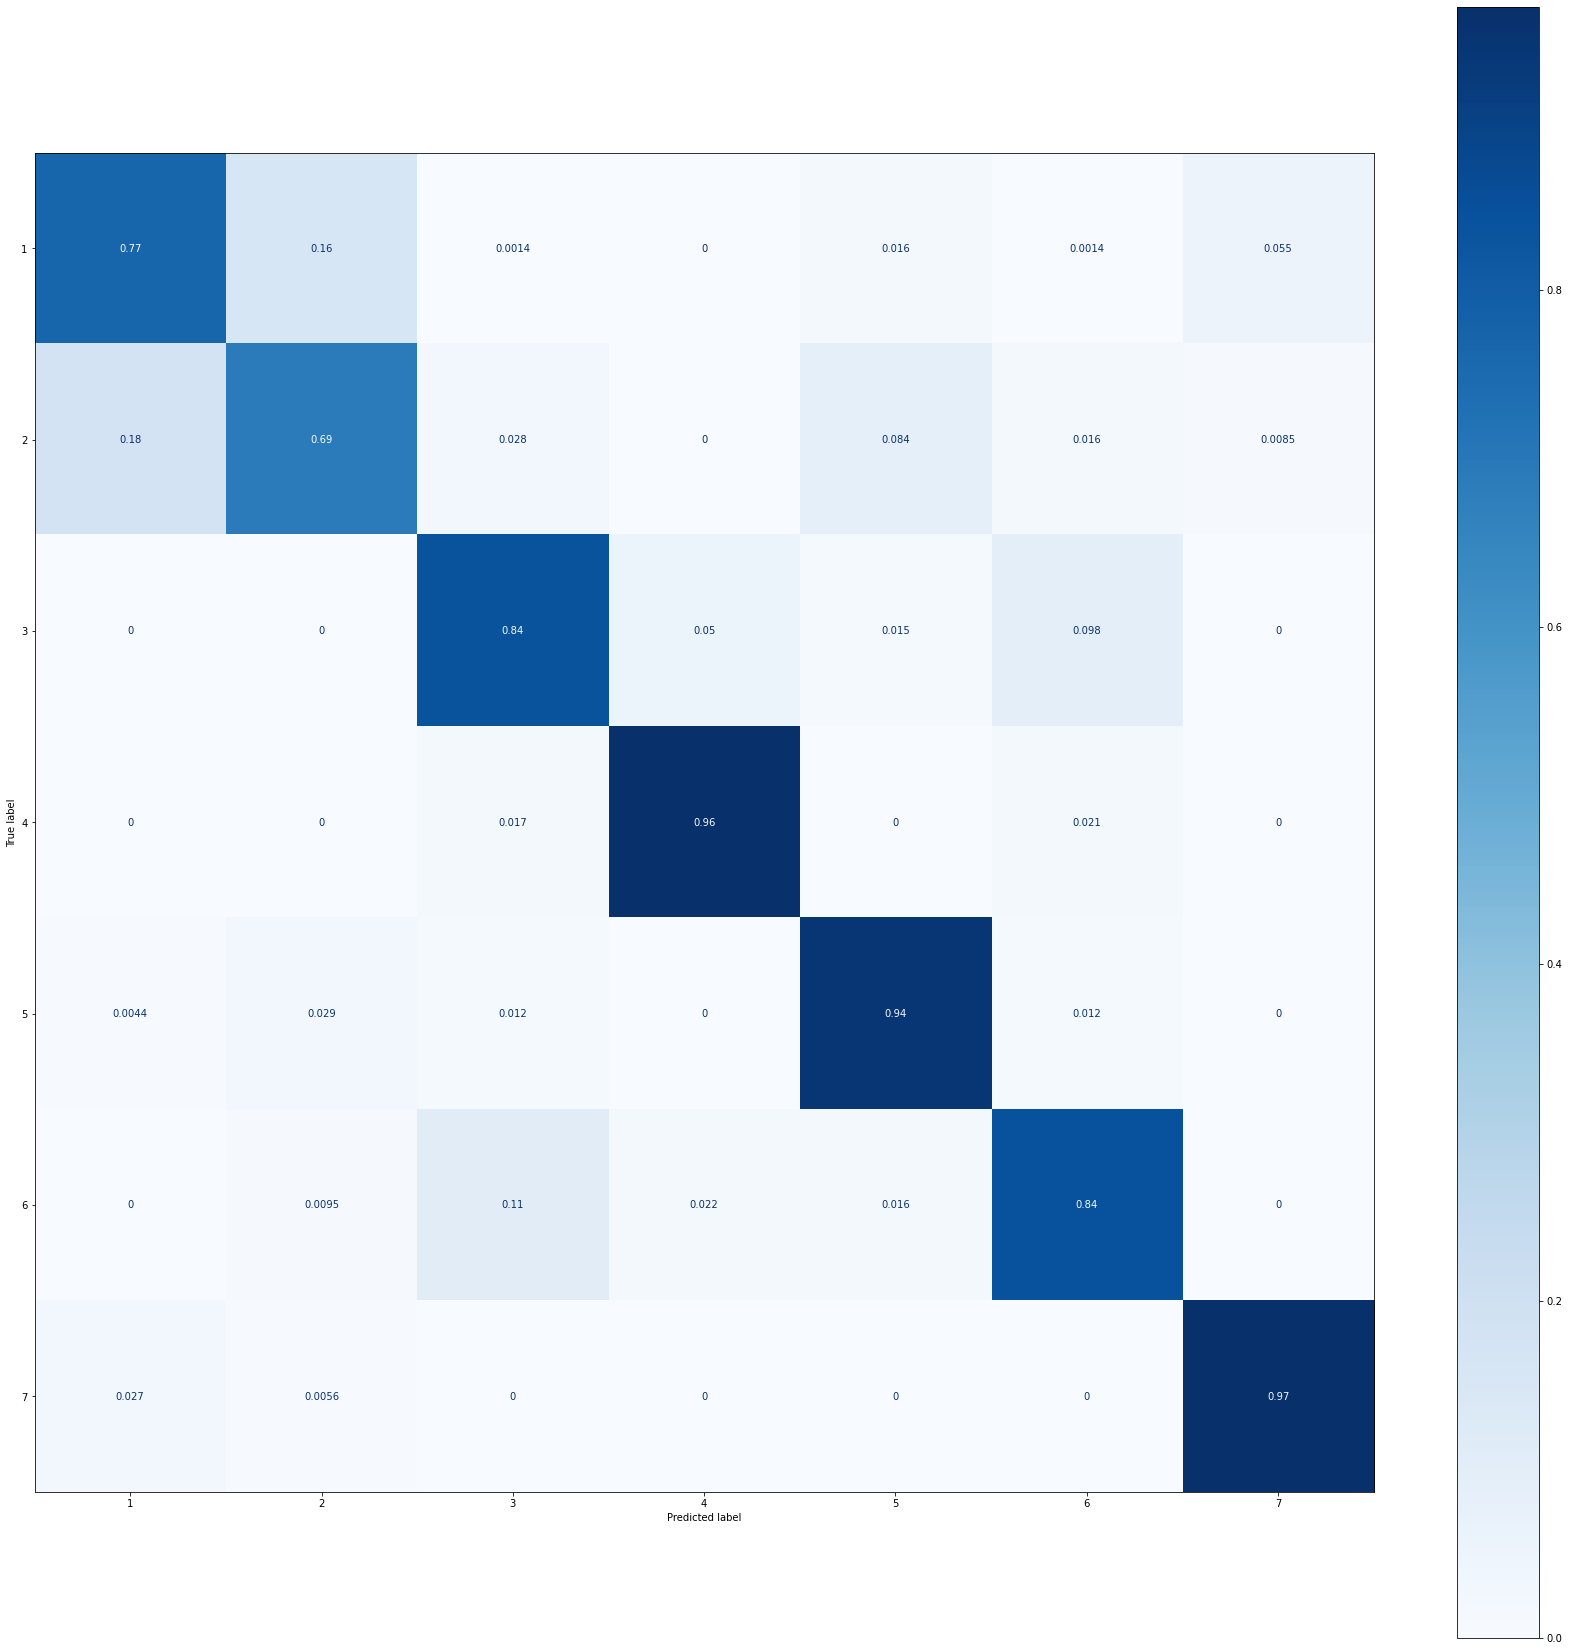

VotingClassifier(estimators=[('rf1',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
       

In [305]:
# Voting
models = [('rf1',RandomForestClassifier(n_jobs=-1, random_state=0)),
           ('rf2',RandomForestClassifier(n_jobs=-1, random_state=0)),
           ('rf3',RandomForestClassifier(n_jobs=-1, random_state=0))]
model = VotingClassifier(models, n_jobs=-1)
score_model(model,df_train);

# Feature Selection

In [336]:
col_normalize = ['Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 
                 'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points',
                 'Horizontal_Distance_To_Roadways']
df_train_norm = df_train.copy()
df_train_norm[col_normalize] = normalize(df_train[col_normalize])
df_train_norm['log_Horizontal_Distance_To_Roadways'] = (df_train['Horizontal_Distance_To_Roadways']+1).apply(np.log)
# df_train_norm.drop(columns=['Soil_Type6','Soil_Type14','Soil_Type5','Soil_Type12'],inplace=True)

cv acc: 0.890079365079365
split acc: 0.8723446893787575
time taken: 8.887207746505737
[0.7642  0.72057 0.86839 0.96779 0.95461 0.85967 0.97195]


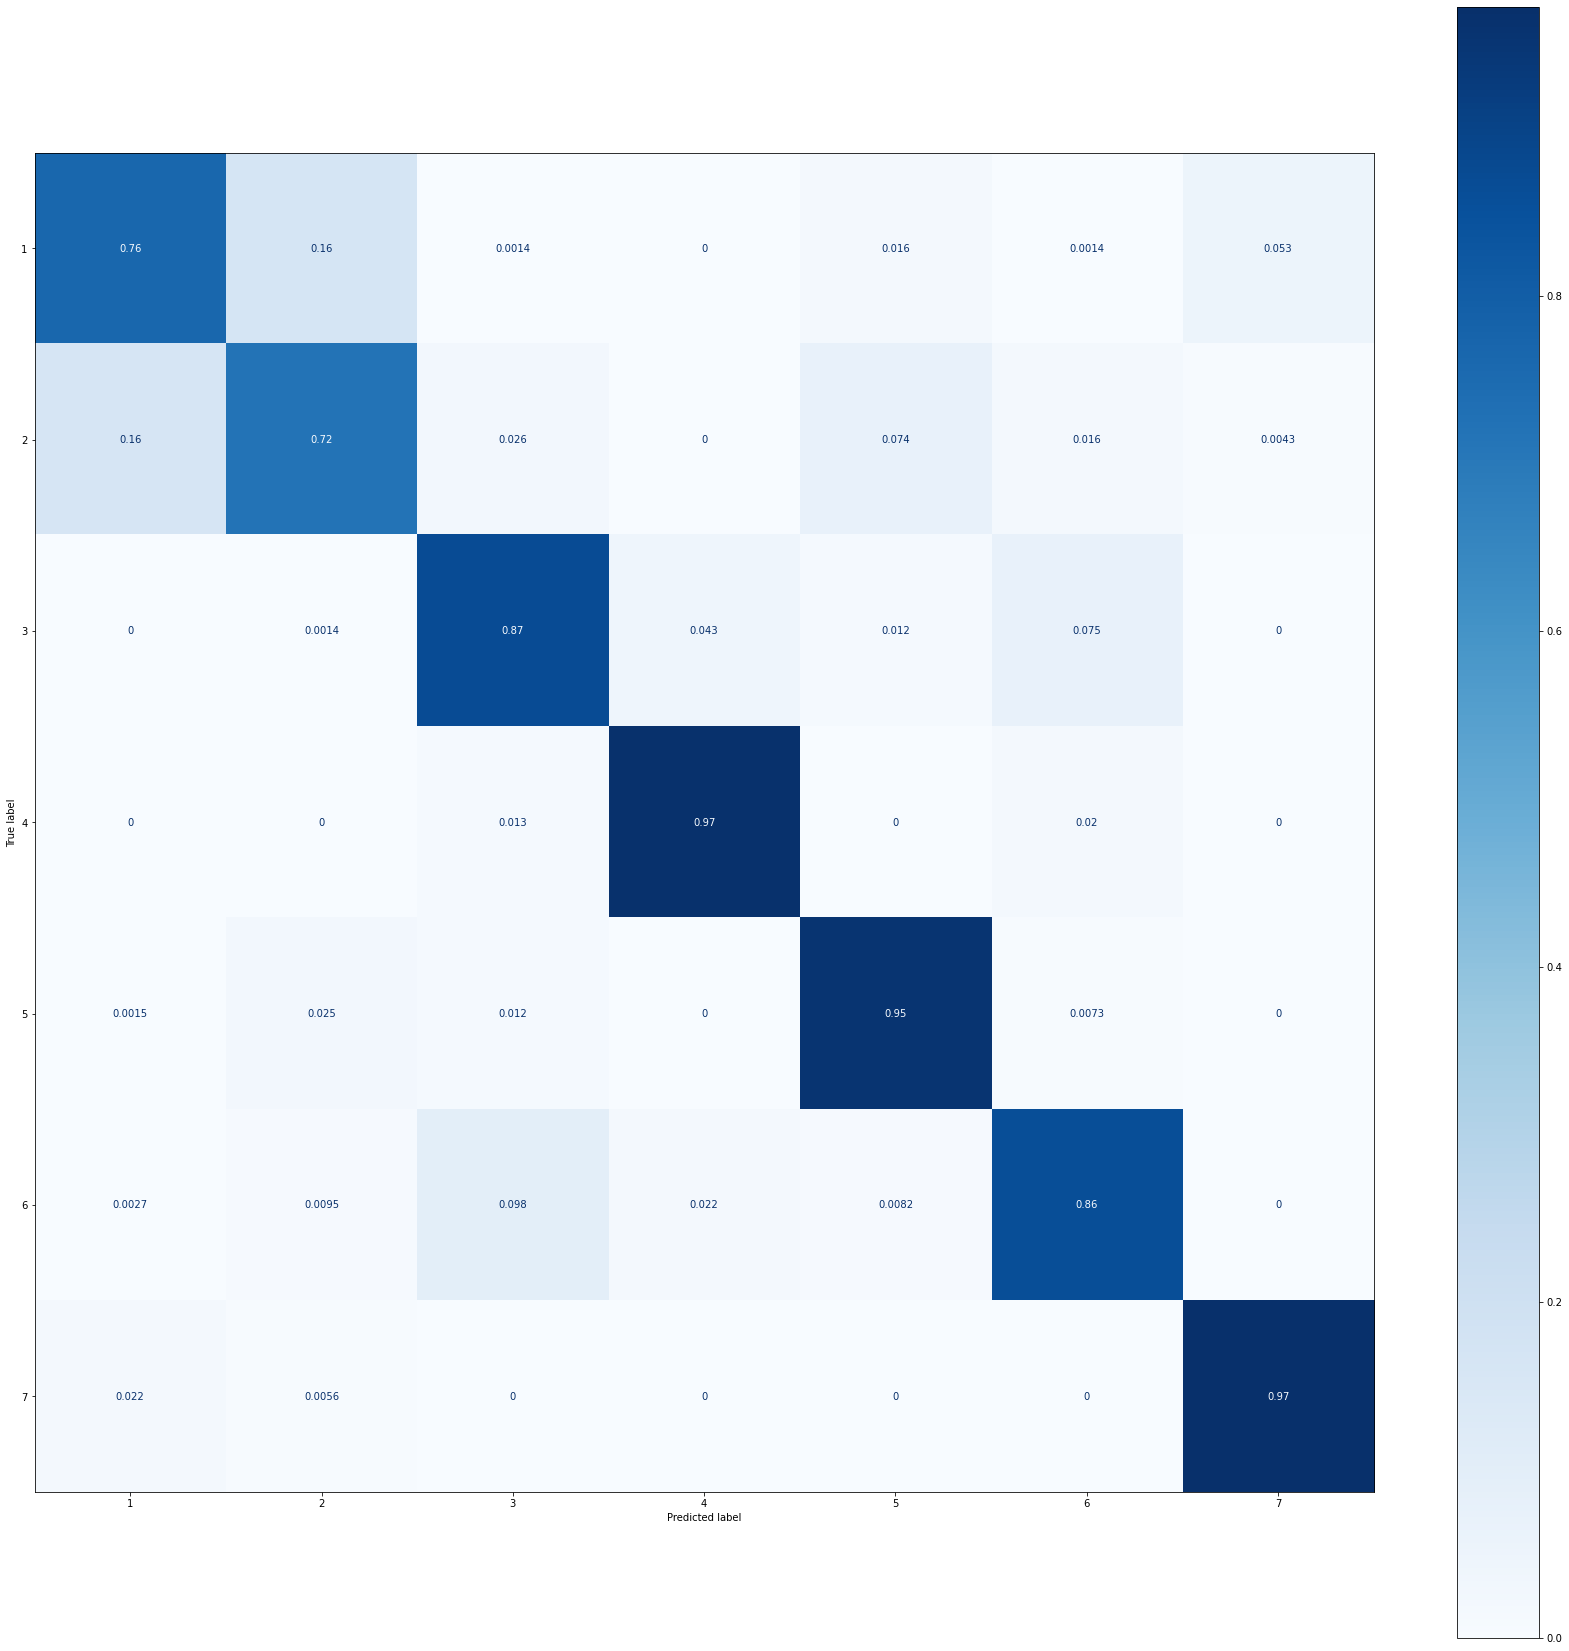

In [429]:
best_m, best_X_train, best_y_train, best_X_val, best_y_val = score_model(ExtraTreesClassifier(n_jobs=-1, random_state=0), df_train_norm, return_train = True, return_val = True)

## Alt2

In [654]:
for v in range(3,4):
    print(v)
    df_train_norm = pipeline(df_train, v)
    best_m, best_X_train, best_y_train, best_X_val, best_y_val = score_model(ExtraTreesClassifier(n_jobs=-1, random_state=0), df_train_norm, return_train = True, return_val = True, display=False)

3
cv acc: 0.9104497354497356
split acc: 0.8905811623246493
time taken: 6.679888725280762



In [342]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= r"http://stream1.cmatc.cn/pub/comet/FireWeather/S290Unit10FuelMoisture/comet/fire/s290/unit10/media/graphics/aspsumm.jpg")

In [600]:
df_train_norm.columns

Index(['Elevation', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15',
       'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19',
       'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23',
       'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27',
       'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31',
       'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35',
       'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39',
       'Soil_Type40', 'Cover_Type', 'log_Ho

cv acc: 0.9104497354497356
split acc: 0.8905811623246493
time taken: 11.994960069656372

[0.79545 0.74468 0.89009 0.97479 0.96779 0.88556 0.97616]


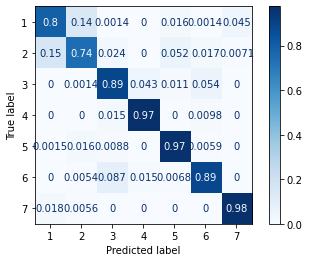

In [671]:
results = []
df_train_norm = pipeline(df_train, 3)
best_m, best_acc = score_model(ExtraTreesClassifier(n_jobs=-1, random_state=0), df_train_norm, 
                       return_cv_acc = True, 
                       display=True, show_weights=False, verbose=True)
# results.append((best_acc,a,b,c))
# pd.DataFrame(results,columns=['acc','fr',"fh",'hr']).sort_values('acc', ascending=False).head(5)

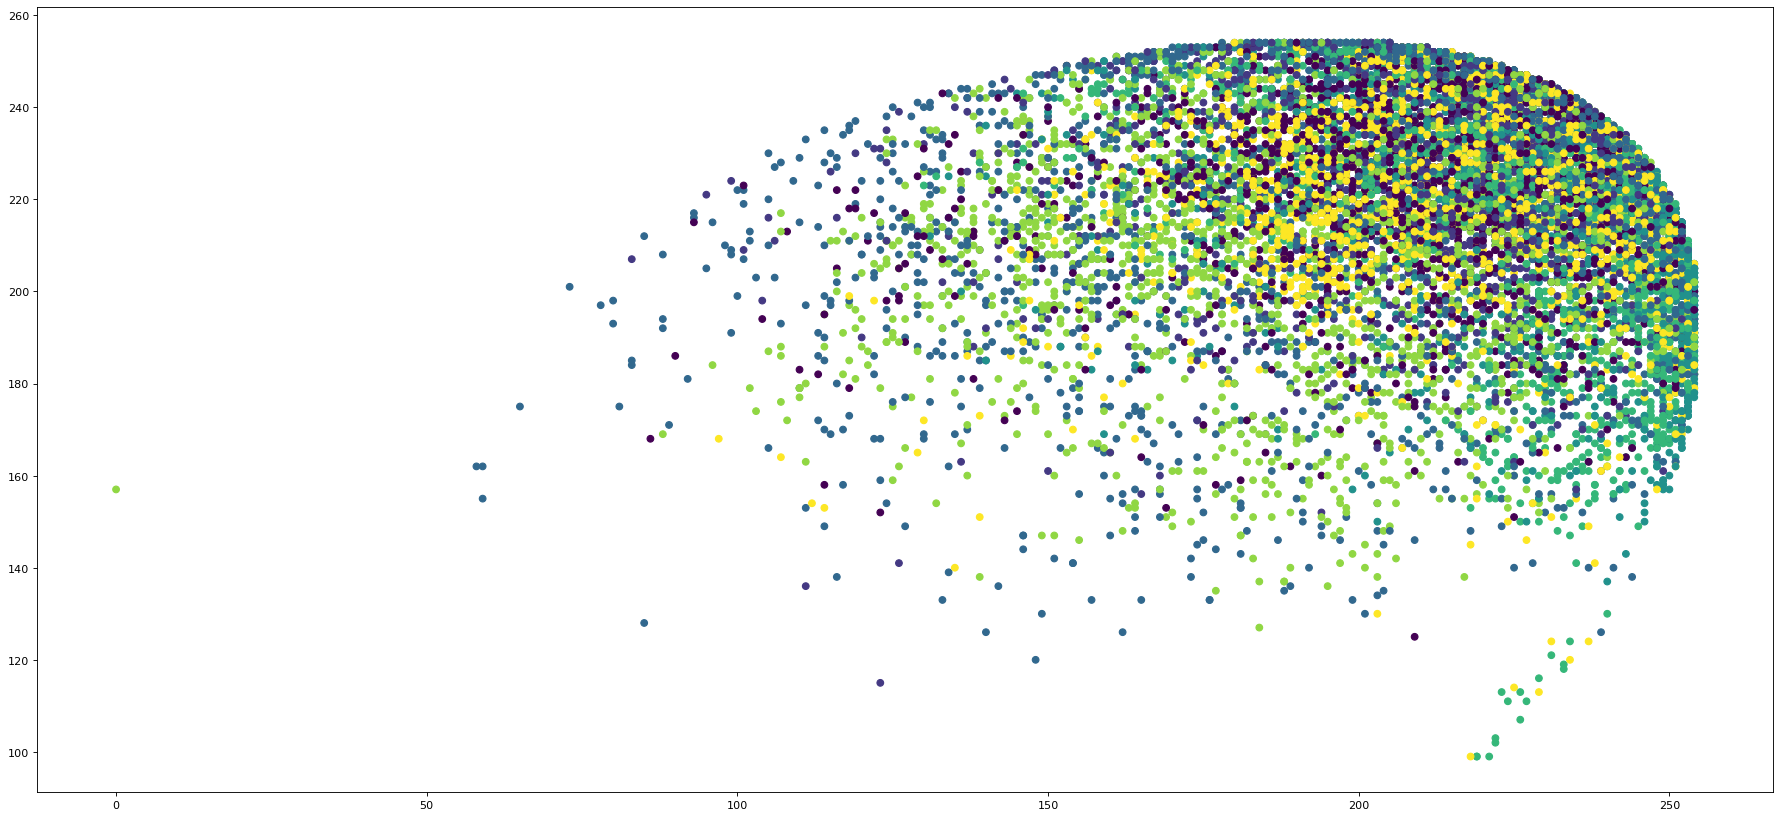

In [658]:
plt.figure(figsize=(28,13), dpi= 80)
plt.scatter(df_train.Hillshade_9am,df_train.Hillshade_Noon, c=df_train.Cover_Type)
plt.show()

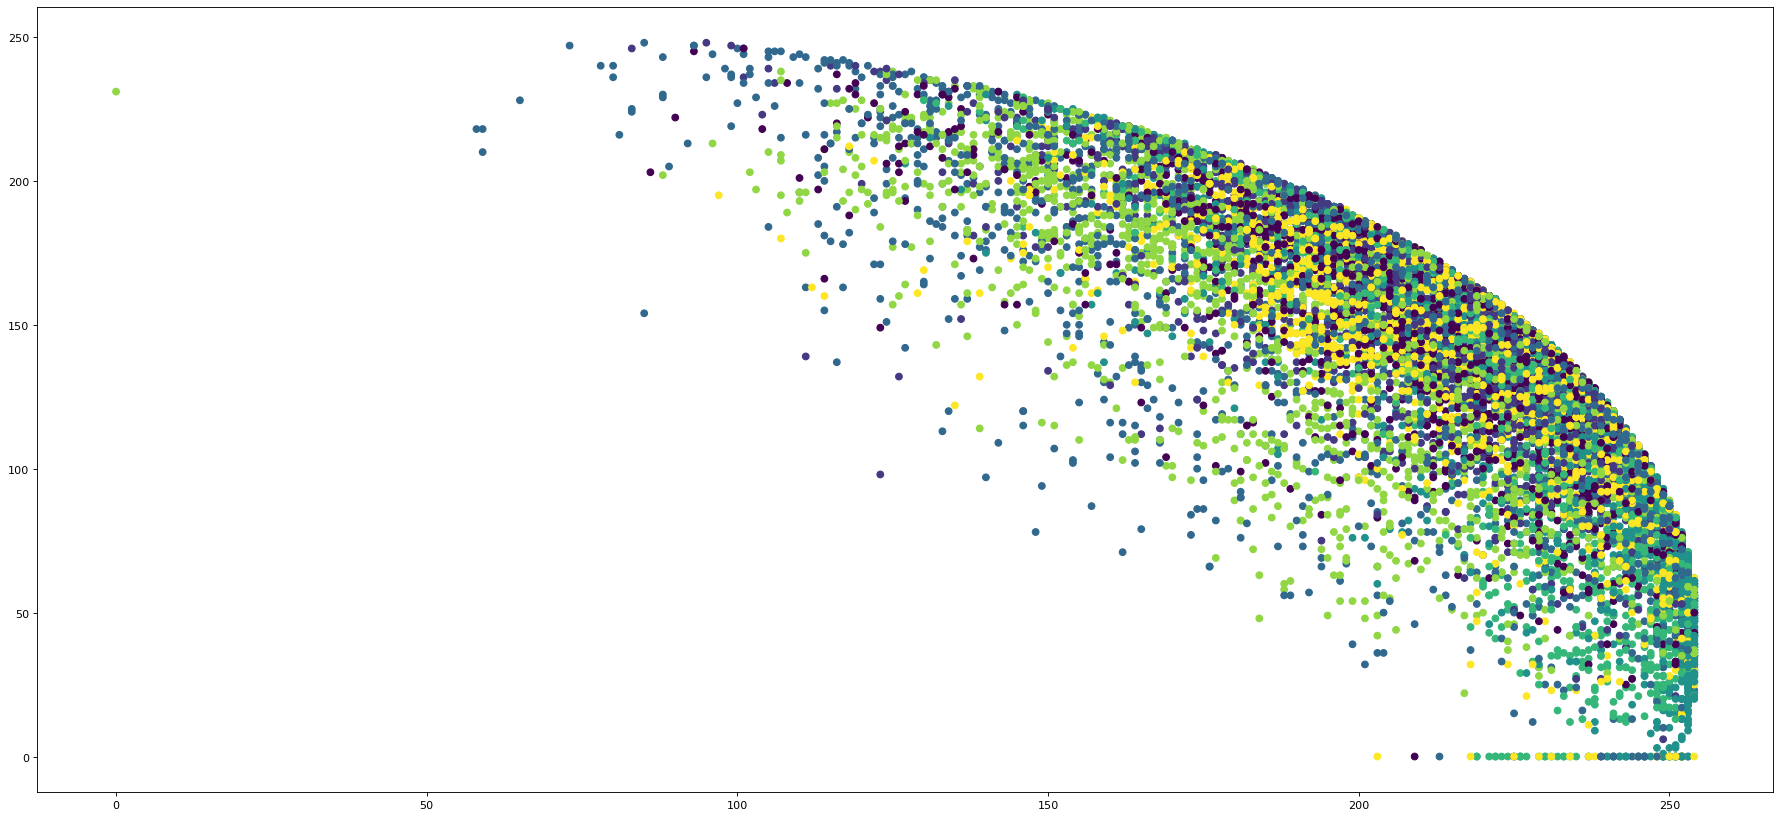

In [659]:
plt.figure(figsize=(28,13), dpi= 80)
plt.scatter(df_train.Hillshade_9am,df_train.Hillshade_3pm, c=df_train.Cover_Type)
plt.show()

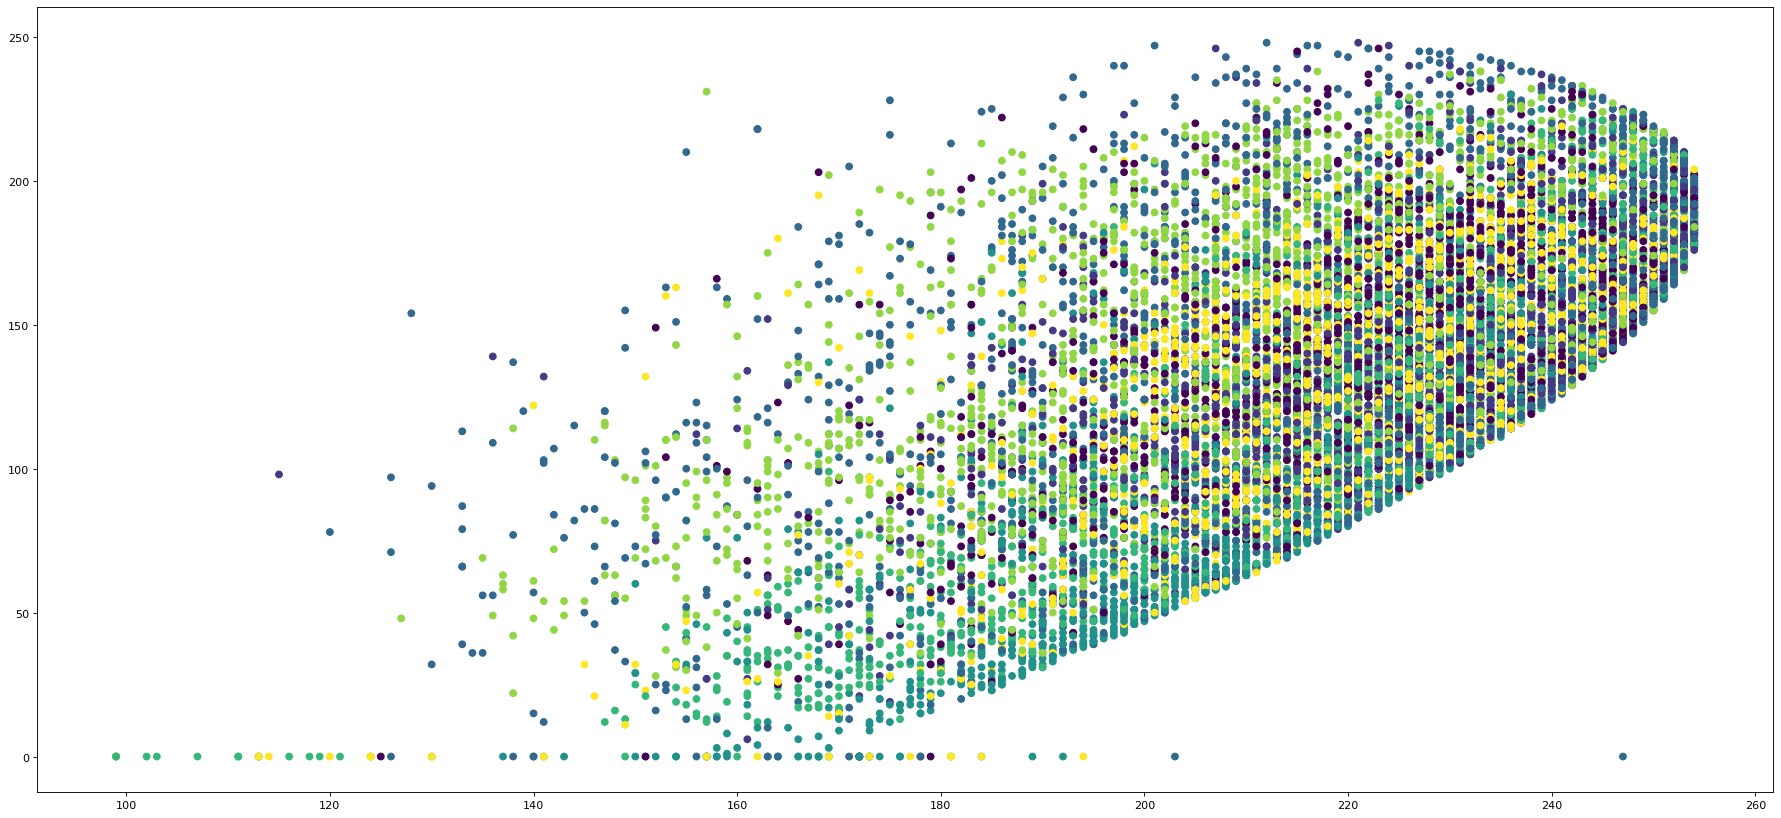

In [660]:
plt.figure(figsize=(28,13), dpi= 80)
plt.scatter(df_train.Hillshade_Noon,df_train.Hillshade_3pm, c=df_train.Cover_Type)
plt.show()

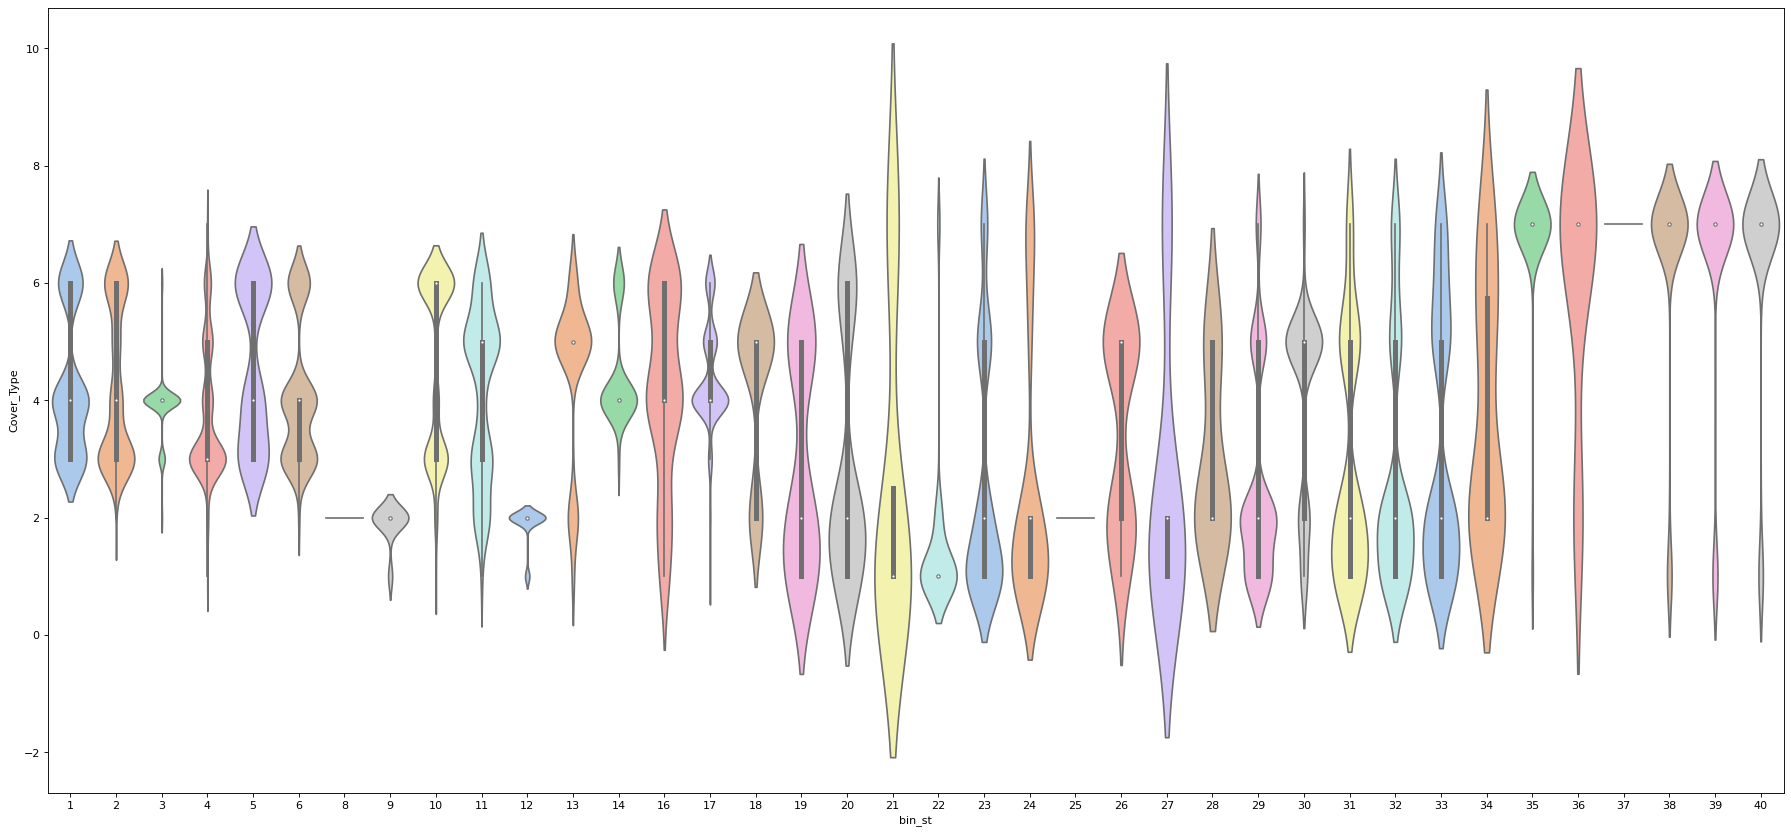

In [328]:
# for st in soil_types:
plt.figure(figsize=(28,13), dpi= 80)
sns.violinplot(x='bin_st', y='Cover_Type', data=df_soil, scale='width', inner='box', palette=sns.color_palette("pastel"))
plt.show()

# Alternative Models 

## Catboost

Reasons to Use:<br>
* missing values numeric variables
* non-encoded categorical variables
* interpretable

In [111]:
import ipywidgets as widgets
from IPython.core.display import display, clear_output
from ipywidgets import interact

In [150]:
# df = df_train
df = df_train_dir.copy()
df = df.drop(columns=['Id','Cover_Type'])
X , Y = df.to_numpy(), df_train.Cover_Type.to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=.33, random_state=0)

cat_features = [df.columns.get_loc(c) for c in df.columns if "Soil_Type" in c or "Wilderness_Area" in c]

cv_dataset = Pool(data=X,
                  label=Y,
                  cat_features=cat_features,
                 )

In [152]:
params = {"iterations": 1000,
          "loss_function": "MultiClassOneVsAll", # MultiClass
          "verbose": False}

scores = cv(cv_dataset,
            params=params,
            nfold=10, 
           )

1 - scores[[x for x  in scores.columns if 'mean' in x]].apply(min)

test-MultiClassOneVsAll-mean     0.871028
train-MultiClassOneVsAll-mean    0.885728
dtype: float64

In [212]:
params = {"iterations": 1000,
          "loss_function": "MultiClass", # MultiClass
          "verbose": False}

scores = cv(cv_dataset,
            params=params,
            nfold=10, 
           )

1 - scores[[x for x  in scores.columns if 'mean' in x]].apply(min)

test-MultiClass-mean     0.543036
train-MultiClass-mean    0.615922
dtype: float64

In [151]:
booster = CatBoostClassifier(
#                               n_estimators=100,
#                               max_depth=10,
#                               learning_rate=0.1,
                              random_state=0,
                              objective='MultiClass', #OneVsAll
#                               iterations=100,
                              )

booster.fit(X_train, y_train, 
             cat_features = cat_features,
             plot=False, verbose=200,
             early_stopping_rounds=100,
            )

test_preds = booster.predict(X_val)
train_preds = booster.predict(X_train)

print("Train Accuracy : %.2f"%booster.score(X_train, y_train))
print("\nTest  Accuracy : %.2f"%booster.score(X_val, y_val))

for w,k in sorted(list(zip(booster.get_feature_importance(), df.columns)), key=lambda x: x[0]):
    print(k,w)

Learning rate set to 0.089045
0:	learn: 1.7615307	total: 9.55ms	remaining: 9.54s
200:	learn: 0.4557665	total: 1.52s	remaining: 6.04s
400:	learn: 0.3425556	total: 2.99s	remaining: 4.46s
600:	learn: 0.2808176	total: 4.41s	remaining: 2.93s
800:	learn: 0.2349416	total: 5.84s	remaining: 1.45s
999:	learn: 0.1996116	total: 7.27s	remaining: 0us
Train Accuracy : 0.96

Test  Accuracy : 0.85
Soil_Type8 0.0
Soil_Type15 0.0
Soil_Type37 0.0
Soil_Type25 5.3561915337154696e-05
Soil_Type9 0.00018368727561305493
Soil_Type28 0.00037792397506379935
Soil_Type36 0.0006470755969096227
Soil_Type18 0.0006998265600674246
Soil_Type21 0.002538917060706616
Soil_Type19 0.0033723456057651114
Soil_Type34 0.008996365955168315
Soil_Type27 0.009105491371237198
Soil_Type26 0.010348797227658383
Soil_Type35 0.011197475993469878
Soil_Type40 0.01725238483118321
Soil_Type14 0.017663046677007462
Soil_Type16 0.026070668009519734
Soil_Type1 0.043895398245565445
Soil_Type5 0.04508289296024852
Soil_Type20 0.07934328907748922
Wilde

### V1

In [221]:
df = pipeline(df_train, '1')
df = df.drop(columns=['Id','Cover_Type'])
X , Y = df.to_numpy(), df_train.Cover_Type.to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=.33, random_state=0)

cat_features = [df.columns.get_loc(c) for c in df.columns if "Soil_Type" in c or "Wilderness_Area" in c]

cv_dataset = Pool(data=X,
                  label=Y,
                  cat_features=cat_features,
                 )

In [223]:
params = {"iterations": 1000,
          "loss_function": "MultiClassOneVsAll", # MultiClass
          "verbose": False}

scores = cv(cv_dataset,
            params=params,
            nfold=10, 
           )

1 - scores[[x for x  in scores.columns if 'mean' in x]].apply(min)

test-MultiClassOneVsAll-mean     0.871065
train-MultiClassOneVsAll-mean    0.885971
dtype: float64

In [224]:
params = {"iterations": 1000,
          "loss_function": "MultiClass", # MultiClass
          "verbose": False}

scores = cv(cv_dataset,
            params=params,
            nfold=10, 
           )

1 - scores[[x for x  in scores.columns if 'mean' in x]].apply(min)

test-MultiClass-mean     0.546005
train-MultiClass-mean    0.620172
dtype: float64

In [225]:
booster = CatBoostClassifier(
#                               n_estimators=100,
#                               max_depth=10,
#                               learning_rate=0.1,
                              random_state=0,
                              objective='MultiClass', #OneVsAll
#                               iterations=100,
                              )

booster.fit(X_train, y_train, 
             cat_features = cat_features,
             plot=False, verbose=200,
             early_stopping_rounds=100,
            )

test_preds = booster.predict(X_val)
train_preds = booster.predict(X_train)

print("Train Accuracy : %.2f"%booster.score(X_train, y_train))
print("\nTest  Accuracy : %.2f"%booster.score(X_val, y_val))

for w,k in sorted(list(zip(booster.get_feature_importance(), df.columns)), key=lambda x: x[0]):
    print(k,w)

Learning rate set to 0.089045
0:	learn: 1.7681959	total: 9.45ms	remaining: 9.44s
200:	learn: 0.4571941	total: 1.46s	remaining: 5.81s
400:	learn: 0.3454389	total: 2.92s	remaining: 4.36s
600:	learn: 0.2808739	total: 4.36s	remaining: 2.9s
800:	learn: 0.2361533	total: 5.79s	remaining: 1.44s
999:	learn: 0.2007681	total: 7.23s	remaining: 0us
Train Accuracy : 0.96

Test  Accuracy : 0.84
Soil_Type8 0.0
Soil_Type15 0.0
Soil_Type37 0.0
Soil_Type25 4.5403770259579595e-05
Soil_Type9 0.0004482293929322674
Soil_Type18 0.0007010075264368416
Soil_Type28 0.0007665600967396696
Soil_Type36 0.001061361931835139
Soil_Type19 0.0018948995689125146
Soil_Type21 0.002066936234291407
Soil_Type34 0.009402121481528464
Soil_Type27 0.009488393302318267
Soil_Type26 0.01109011292942023
Soil_Type35 0.013289079594621939
Soil_Type14 0.014663916984222659
Soil_Type16 0.02253362572471905
Soil_Type1 0.031793973792809
Soil_Type5 0.04312804488253053
Soil_Type40 0.06434236752701851
Soil_Type20 0.0749656515550684
Wilderness_Area

In [225]:
booster = CatBoostClassifier(
#                               n_estimators=100,
#                               max_depth=10,
#                               learning_rate=0.1,
                              random_state=0,
                              objective='MultiClass', #OneVsAll
#                               iterations=100,
                              )

booster.fit(X_train, y_train, 
             cat_features = cat_features,
             plot=False, verbose=200,
             early_stopping_rounds=100,
            )

test_preds = booster.predict(X_val)
train_preds = booster.predict(X_train)

print("Train Accuracy : %.2f"%booster.score(X_train, y_train))
print("\nTest  Accuracy : %.2f"%booster.score(X_val, y_val))

for w,k in sorted(list(zip(booster.get_feature_importance(), df.columns)), key=lambda x: x[0]):
    print(k,w)

Learning rate set to 0.089045
0:	learn: 1.7681959	total: 9.45ms	remaining: 9.44s
200:	learn: 0.4571941	total: 1.46s	remaining: 5.81s
400:	learn: 0.3454389	total: 2.92s	remaining: 4.36s
600:	learn: 0.2808739	total: 4.36s	remaining: 2.9s
800:	learn: 0.2361533	total: 5.79s	remaining: 1.44s
999:	learn: 0.2007681	total: 7.23s	remaining: 0us
Train Accuracy : 0.96

Test  Accuracy : 0.84
Soil_Type8 0.0
Soil_Type15 0.0
Soil_Type37 0.0
Soil_Type25 4.5403770259579595e-05
Soil_Type9 0.0004482293929322674
Soil_Type18 0.0007010075264368416
Soil_Type28 0.0007665600967396696
Soil_Type36 0.001061361931835139
Soil_Type19 0.0018948995689125146
Soil_Type21 0.002066936234291407
Soil_Type34 0.009402121481528464
Soil_Type27 0.009488393302318267
Soil_Type26 0.01109011292942023
Soil_Type35 0.013289079594621939
Soil_Type14 0.014663916984222659
Soil_Type16 0.02253362572471905
Soil_Type1 0.031793973792809
Soil_Type5 0.04312804488253053
Soil_Type40 0.06434236752701851
Soil_Type20 0.0749656515550684
Wilderness_Area

In [230]:
pred = booster.predict(X_val)
acc = accuracy_score(y_val, pred)
matrix = cm(y_val, pred)
print(matrix.diagonal() / matrix.sum(axis=1))

[0.74006 0.66667 0.82497 0.96919 0.93265 0.82016 0.95792]


## NN

In [721]:
m_train_x, m_train_y, m_val_x, m_val_y

(array([[2.97700e+03, 2.91609e-02, 8.16504e-03, ..., 0.00000e+00,
         0.00000e+00, 7.38833e+00],
        [3.37700e+03, 3.27817e-02, 1.35182e-03, ..., 0.00000e+00,
         0.00000e+00, 7.35308e+00],
        [2.72800e+03, 1.35070e-01, 9.41397e-03, ..., 0.00000e+00,
         0.00000e+00, 7.06305e+00],
        ...,
        [3.51500e+03, 4.59234e-02, 7.84767e-03, ..., 0.00000e+00,
         0.00000e+00, 8.07776e+00],
        [2.57500e+03, 3.95788e-02, 1.73157e-02, ..., 0.00000e+00,
         0.00000e+00, 7.42536e+00],
        [2.73800e+03, 1.42281e-01, 4.21226e-03, ..., 0.00000e+00,
         0.00000e+00, 7.57712e+00]]),
 array([2, 7, 6, ..., 7, 3, 5], dtype=int64),
 array([[2.22000e+03, 1.87704e-02, 1.25136e-02, ..., 0.00000e+00,
         0.00000e+00, 6.72022e+00],
        [2.13900e+03, 9.95033e-02, 8.36162e-03, ..., 0.00000e+00,
         0.00000e+00, 6.83948e+00],
        [2.29200e+03, 6.31821e-02, 1.50710e-02, ..., 0.00000e+00,
         0.00000e+00, 6.77651e+00],
        ...,
        

In [104]:
# NN
model = Sequential()
model.add( Dense(100, input_dim=m_train_x.shape[1], activation='relu'))
model.add( Dense(200, activation='relu'))
model.add( Dense(200, activation='relu'))
model.add( Dense(500, activation='relu'))
model.add( Dense(200, activation='relu'))
model.add( Dense(200, activation='relu'))
model.add( Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
estimator = KerasClassifier(build_fn=model, epochs=200, batch_size=5, verbose=2)
# score_model(estimator, df_train_alt)
# results = model_selection.cross_val_score(model, X, Y, cv=kfold)

df = df_train_alt
X , Y = df.drop(columns=['Id','Cover_Type']).to_numpy(), df.Cover_Type.to_numpy()

enc = OneHotEncoder()
new_train_y = enc.fit_transform(m_train_y.reshape(-1,1))
new_val_y = enc.transform(m_val_y.reshape(-1,1))

model.fit(m_train_x, new_y, validation_split=.33, epochs=200, verbose=2)

NameError: name 'm_train_x' is not defined

# Tuning Hyperparameters



100
--------------------------------------------------
cv acc: 0.8998677248677248
split acc: 0.8803607214428858
time taken: 8.632887840270996



200
--------------------------------------------------
cv acc: 0.899537037037037
split acc: 0.8821643286573146
time taken: 15.404508352279663



300
--------------------------------------------------
cv acc: 0.9007936507936508
split acc: 0.8813627254509018
time taken: 21.715052127838135



400
--------------------------------------------------
cv acc: 0.9010582010582009
split acc: 0.8819639278557114
time taken: 28.32905602455139



500
--------------------------------------------------
cv acc: 0.9013227513227513
split acc: 0.8819639278557114
time taken: 36.2212450504303



600
--------------------------------------------------
cv acc: 0.9017195767195767
split acc: 0.8821643286573146
time taken: 43.90354800224304



700
--------------------------------------------------
cv acc: 0.9011904761904763
split acc: 0.8825651302605211
time taken: 51.9

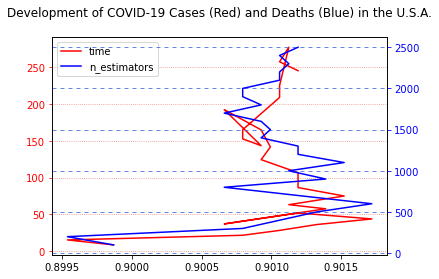

In [452]:
df_train_alt = pipeline(df_train, 2)

tree_size_acc = []
for n in range(100,1501,100):
    print('\n\n{}\n'.format(n)+'-'*50)
    m, acc, time_taken = score_model(ExtraTreesClassifier(n_estimators=n,n_jobs=-1, random_state=0), df_train_alt, display=False, return_cv_acc=True, return_time=True)
    tree_size_acc.append((n,acc,time_taken))

fig, ax = plt.subplots()
# ax1 for # time
l1 = ax.plot(np.array(tree_size_acc)[:,1], np.array(tree_size_acc)[:,2], 'r', label='time')
ax.tick_params('y', colors='r')
ax.grid(axis='y', color='lightcoral', linestyle=':')
# ax2 for # n_estimators
ax2 = ax.twinx()
l2 = ax2.plot(np.array(tree_size_acc)[:,1], np.array(tree_size_acc)[:,0], 'b', label='n_estimators')
ax2.tick_params('y', colors='b')
ax2.grid(axis='y', color='royalblue', linestyle=(0,(5,5)))
# general plot
lines = l1 + l2
labels = [l.get_label() for l in lines]
ax.legend(lines,labels)
plt.title("Development of COVID-19 Cases (Red) and Deaths (Blue) in the U.S.A.\n")
plt.show()
print('best = ',sorted(tree_size_acc, key=lambda x: x[1], reverse=True)[0])

# Submit

In [477]:
submit(ExtraTreesClassifier(n_estimators=800, n_jobs=-1, random_state=0), 1).to_csv('submit-1.csv', index=False)
# submit(ExtraTreesClassifier(n_estimators=600, n_jobs=-1, random_state=0), 2).to_csv('submit-2.csv', index=False)